In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from tqdm.auto import tqdm
sys.path.append("../")
import library

# Question 1

In [31]:
def power_method(A :list,x0: list,tol = 1e-6):
    
    A = np.array(A)
    x0 = np.array(x0)
    x_copy = np.copy(x0)
    lam_0 = np.matmul(np.matmul(np.linalg.matrix_power(A,2),x0).T,np.matmul(np.linalg.matrix_power(A,1),x0))/np.matmul(np.matmul(np.linalg.matrix_power(A,1),x0).T,np.matmul(np.linalg.matrix_power(A,1),x0))
    lam_1 = np.matmul(np.matmul(np.linalg.matrix_power(A,3),x0).T,np.matmul(np.linalg.matrix_power(A,2),x0))/np.matmul(np.matmul(np.linalg.matrix_power(A,2),x0).T,np.matmul(np.linalg.matrix_power(A,2),x0))
    i=3
    while abs(lam_1-lam_0)>tol:
        lam_0 = lam_1
        lam_1 = np.matmul(np.matmul(np.linalg.matrix_power(A,i+1),x0).T,np.matmul(np.linalg.matrix_power(A,i),x0))/np.matmul(np.matmul(np.linalg.matrix_power(A,i),x0).T,np.matmul(np.linalg.matrix_power(A,i),x0))
        i+=1

    eigval = lam_1
    eigvec = np.matmul(np.linalg.matrix_power(A,i-1),x_copy)
    norm = np.linalg.norm(eigvec)
    eigvec = eigvec/norm
    return eigval,eigvec,i  


In [32]:
A = np.array([[4, 2/3, -4/3, 4/3],
              [2/3, 4, 0, 0],
              [-4/3, 0, 6, 2],
              [4/3, 0, 2, 6]])

# Defining the initial guess
x0 = np.array([1, 1, 1, 1])

eigval, eigvec,steps = power_method(A, x0)

print("Largest Eigenvalue: ", np.round(eigval, 4))
print("Number of steps: ", steps)

Largest Eigenvalue:  8.0
Number of steps:  25


In [33]:
def QR(A,tolerance = 1e-6):
    A = np.array(A)
    copy_A = np.copy(A)
    Q,R = QR_factorize(A)
    A = np.matmul(R,Q)
    i=1
    while np.linalg.norm(A-copy_A)>tolerance:
        copy_A = np.copy(A)
        Q,R = QR_factorize(A)
        A = np.matmul(R,Q)
        i+=1
    return np.diag(A),i

def QR_factorize(A):
    A = np.array(A) if type(A) != np.ndarray else A
    Q = np.zeros(A.shape)
    R = np.zeros(A.shape)
    for i in range(A.shape[1]):
        u_i = A[:,i]
        sum = 0
        for j in range(i):
            sum += np.dot(A[:,i],Q[:,j])*Q[:,j]
        u_i = u_i - sum
        Q[:,i] = u_i/np.linalg.norm(u_i)
        for j in range(i+1):
            R[j,i] = np.dot(A[:,i],Q[:,j])
            
    return Q,R

In [34]:
eigval,steps = QR(A)
print("Eigenvalues using QR method: ", eigval)
print("Number of steps: ", steps)

Eigenvalues using QR method:  [6. 4. 8. 2.]
Number of steps:  21


# Question 2

In [46]:
data = library.io.read_sequential_data("./assign3fit.txt",separator=" \t")

In [49]:
data = np.array(data)
x = np.array(data[0])
y = np.array(data[1])

In [50]:
def polynomial_fit(xlist: list,ylist: list,sigma_list: list,degree: int,tol=1e-6):
    xlist = np.array(xlist)
    ylist = np.array(ylist)
    sigma_list = np.array(sigma_list)
    A_matrix = np.zeros((degree+1,degree+1))

    for i in range(degree+1):
        for j in range(degree+1):
            A_matrix[i][j] = np.sum((xlist**(i+j))/(sigma_list**2))
    B_matrix = np.zeros(degree+1)
    for i in range(degree+1):
        B_matrix[i] = np.sum((ylist*(xlist**i))/(sigma_list**2))
    # a = Gauss_seidel_solve(A_matrix.tolist(),B_matrix.tolist(),T=tol)
    a = np.linalg.solve(A_matrix,B_matrix)    
    return a,A_matrix

def poly_fn(x,coefflist):
    sum = 0
    for i in range(len(coefflist)):
        sum += coefflist[i]*x**i
    return sum  

The coefficients for the fitted polynomial of degree 3 are tabulated as follows:
+-------------+----------+
| Coefficient |  Value   |
+-------------+----------+
|      a0     |  0.5747  |
|      a1     |  4.7259  |
|      a2     | -11.1282 |
|      a3     |  7.6687  |
+-------------+----------+


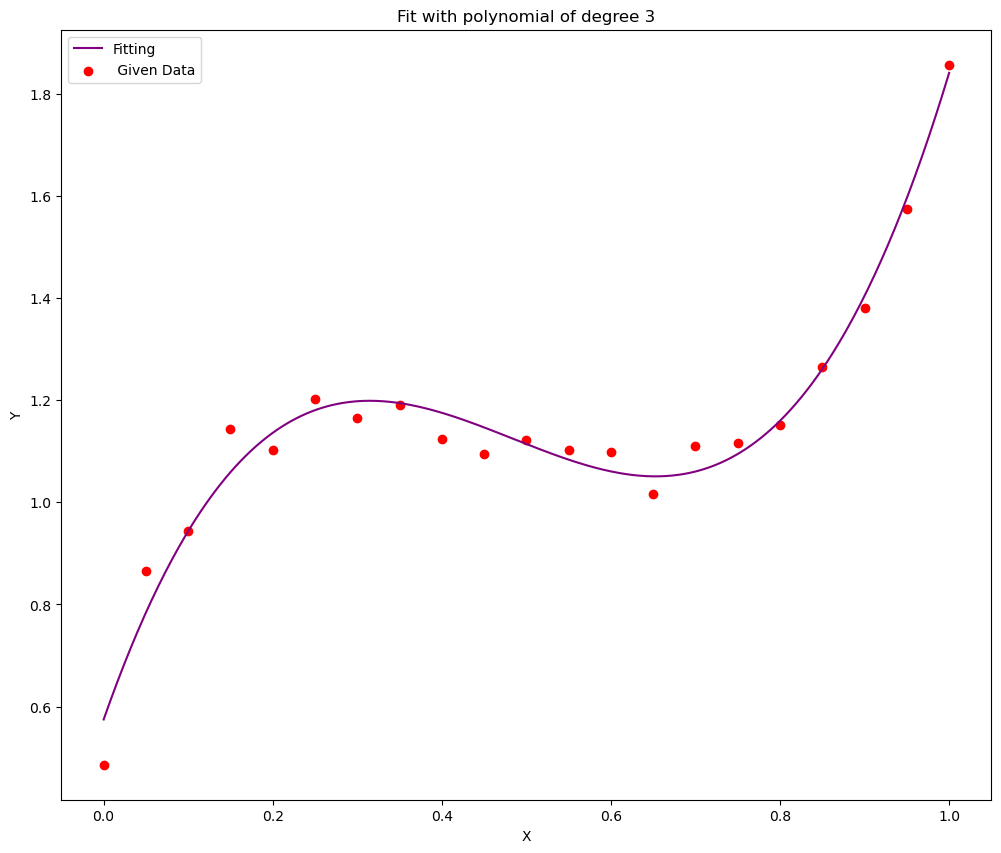

In [51]:
sigma = np.ones(len(x))
coeff_list,A_poly = polynomial_fit(np.copy(x), np.copy(y), np.copy(sigma), 3)


from prettytable import PrettyTable
print("The coefficients for the fitted polynomial of degree 3 are tabulated as follows:")
p=PrettyTable()
table = PrettyTable()
table.field_names = ['Coefficient', 'Value']
for i, coeff in enumerate(coeff_list):
    table.add_row([f'a{i}', np.round(coeff,4)])
print(table) 


import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.scatter(x, y, label=' Given Data', color='red')

xnew = np.linspace(min(x), max(x), 500)
ynew = poly_fn(xnew, coeff_list)

plt.plot(xnew, ynew, label='Fitting', color='purple')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fit with polynomial of degree 3')
plt.legend()
plt.show()

In [52]:
def polynomial_fit_mod_chebyshev(xlist: list,ylist: list,sigma_list: list,degree: int):
    # Defining the modified chebyshev polynomial
    def modified_chebyshev_polynomial(x,degree):
        def chebyshev_polynomial(x,degree):
            if degree == 0:
                return 1
            elif degree == 1:
                return x
            else:
                return 2*x*chebyshev_polynomial(x,degree-1) - chebyshev_polynomial(x,degree-2)
        return chebyshev_polynomial(2*x - 1,degree)
    xlist = np.array(xlist)
    ylist = np.array(ylist)
    sigma_list = np.array(sigma_list)
    A_matrix = np.zeros((degree+1,degree+1))

    for i in range(degree+1):
        for j in range(degree+1):
            # Replace the polynomial with the modified chebyshev polynomial
            A_matrix[i][j] = np.sum((modified_chebyshev_polynomial(xlist,i)*modified_chebyshev_polynomial(xlist,j))/(sigma_list**2))
    B_matrix = np.zeros(degree+1)
    for i in range(degree+1):
        B_matrix[i] = np.sum((ylist*(modified_chebyshev_polynomial(xlist,i)))/(sigma_list**2))
    a = np.linalg.solve(A_matrix,B_matrix)    
    return a,A_matrix

In [53]:
def modified_chebyshev_polynomial(x,degree):
    def chebyshev_polynomial(x,degree):
        if degree == 0:
            return 1
        elif degree == 1:
            return x
        else:
            return 2*x*chebyshev_polynomial(x,degree-1) - chebyshev_polynomial(x,degree-2)
    return chebyshev_polynomial(2*x - 1,degree)


def poly_fn_mod(x,coefflist):
    sum = 0
    for i in range(len(coefflist)):
        sum += coefflist[i]*modified_chebyshev_polynomial(x,i)
    return sum    

The coefficients for the fitting with chebyshev polynomial of degree 3:
+-------------+--------+
| Coefficient | Value  |
+-------------+--------+
|      a0     | 1.161  |
|      a1     | 0.3935 |
|      a2     | 0.0468 |
|      a3     | 0.2396 |
+-------------+--------+


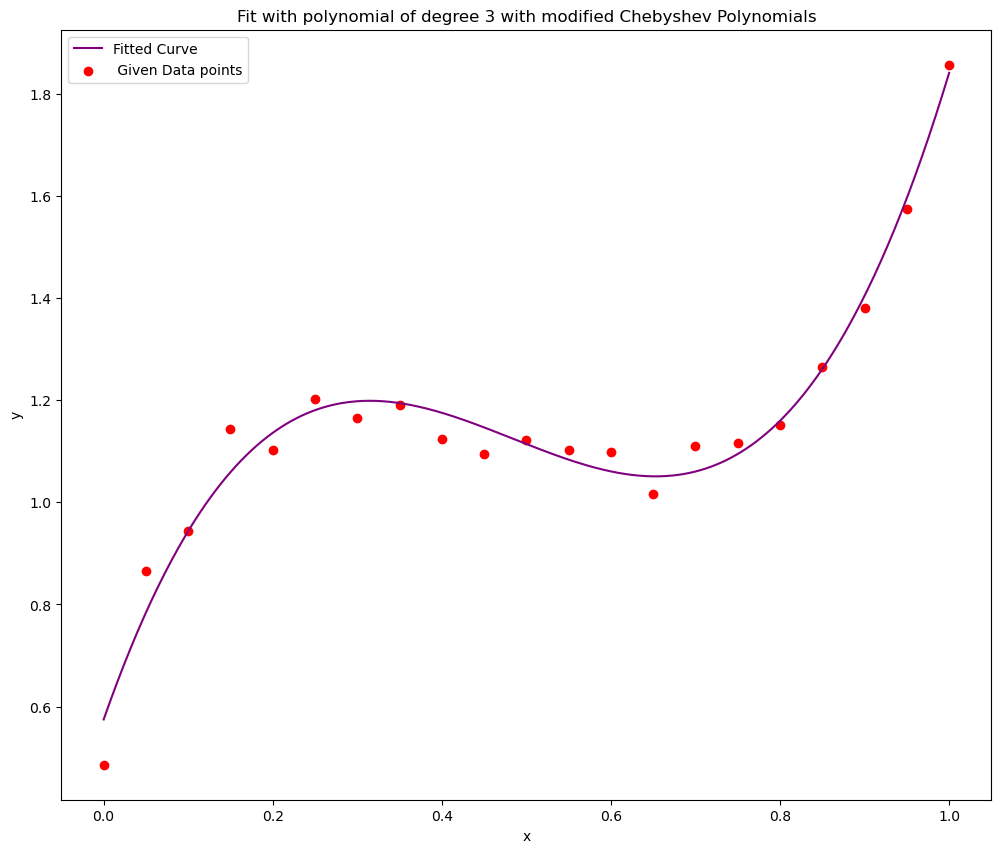

In [58]:
sigma = np.ones(len(x))
coeff_list_mod,A_mod = polynomial_fit_mod_chebyshev(np.copy(x), np.copy(y), np.copy(sigma),3)


print("The coefficients for the fitting with chebyshev polynomial of degree 3:")
p=PrettyTable()
table = PrettyTable()
table.field_names = ['Coefficient', 'Value']
for i, coeff in enumerate(coeff_list_mod):
    table.add_row([f'a{i}', np.round(coeff,4)])
print(table)


plt.figure(figsize=(12,10))
plt.scatter(x, y, label=' Given Data points', color='red')
xlist_new = np.linspace(min(x), max(x), 500)
ylist_new = [poly_fn_mod(x,coeff_list_mod) for x in xlist_new]
plt.plot(xlist_new, ylist_new, label='Fitted Curve', color='purple')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit with polynomial of degree 3 with modified Chebyshev Polynomials')
plt.legend()
plt.show()

In [59]:
CN_poly = np.linalg.cond(A_poly)
CN_mod = np.linalg.cond(A_mod)

p = PrettyTable()
p.field_names = ['Basis', 'Condition Number']
p.add_row(['normal Polynomial fit', CN_poly])
p.add_row(['modified chebyshev Polynomial fit', CN_mod])

print(p)

+-----------------------------------+--------------------+
|               Basis               |  Condition Number  |
+-----------------------------------+--------------------+
|       normal Polynomial fit       | 12104.948671034383 |
| modified chebyshev Polynomial fit | 3.8561465786155766 |
+-----------------------------------+--------------------+


# Question 3 and 4 can be found in the accompanying pdf file